In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install --upgrade transformers
!pip install --upgrade tf_keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 108.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 106.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 77.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 39.8 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
     

While fine-tuning BERT (April 2024), Keras was updated to 3. However, the transformer did not yet support the new version, so this string of code forced Keras to run on the old version.

In [ ]:
# Restart session
# Run keras 2
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'

In [ ]:
# Data mainpulation
import pandas as pd
import numpy as np
# Plot
import matplotlib.pyplot as plt

In [ ]:
# Modeling
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from tensorflow.keras.optimizers import Adam
from transformers import TFAutoModelForSequenceClassification, AdamWeightDecay
from tensorflow.keras.optimizers import SGD

In [ ]:
# Tuning
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.callbacks import EarlyStopping
# Train test split
from sklearn.model_selection import train_test_split
# Import accuracy_score to check performance
from sklearn.metrics import accuracy_score

In [ ]:
train = pd.read_excel('/.../train_set05.xlsx')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   textDisplay  4000 non-null   object
 1   label        4000 non-null   object
dtypes: object(2)
memory usage: 62.6+ KB


In [ ]:
train["label"].value_counts()

label
N    2759
L     495
R     488
H     258
Name: count, dtype: int64

In [ ]:
train['label'] = train['label'].replace('H', 'N')

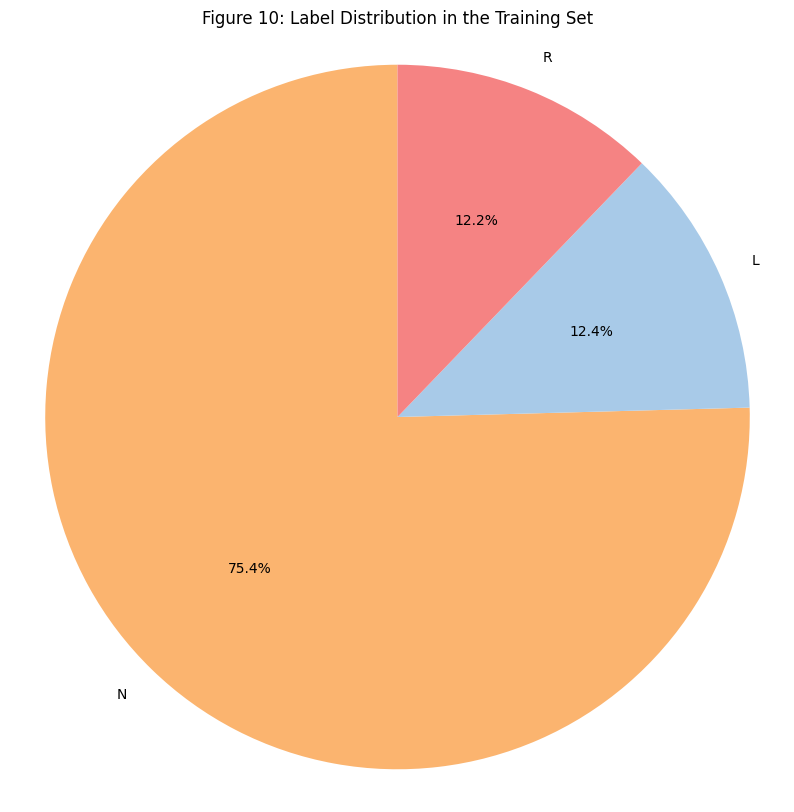

In [ ]:
label_counts = train['label'].value_counts()
colors = ['#FBB46F', '#A8CAE8', '#F58383']

plt.figure(figsize=(10, 10))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90, colors = colors)
plt.title('Figure 10: Label Distribution in the Training Set')
plt.axis('equal')

plt.show()

In [ ]:
train["label"].value_counts()

label
N    3017
L     495
R     488
Name: count, dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train['textDisplay'], train['label'], test_size=0.2, random_state=23)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
tokenized_data_train = tokenizer(X_train.to_list(), return_tensors="np", padding=True)
tokenized_data_test = tokenizer(X_test.to_list(), return_tensors="np", padding=True)

labels_train = np.array(y_train)
labels_test = np.array(y_test)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1346 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
print(tokenized_data_train["input_ids"][0])

[  101  1004 22035 ...     0     0     0]


In [ ]:
# Set up the loss function
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
# Transform labels to integers
label_to_int = {"N": 0, "R": 1, "L": 2}
labels_train = [label_to_int[label] for label in labels_train]
labels_test = [label_to_int[label] for label in labels_test]

In [ ]:
# This chunk was used for clear GPU memory
import tensorflow as tf
tf.keras.backend.clear_session()

In [ ]:
# RandomOverSampler
ros = RandomOverSampler(random_state=23)

# Transformation
X_train_array = np.array(X_train).reshape((-1, 1))

# Oversampling
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_array, labels_train)
X_train_resampled = X_train_resampled.flatten()


# Tokenization
encoded_inputs = tokenizer(X_train_resampled.tolist(), return_tensors="np", padding=True)
input_ids = encoded_inputs["input_ids"]
attention_mask = encoded_inputs["attention_mask"]

# Complie model
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
weighted_loss = lambda y_true, y_pred: loss(y_true, y_pred, sample_weight=tf.gather(class_weight, y_true))
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=0, mode='auto')
model = TFAutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(set(train['label'])))
model.compile(optimizer=Adam(5e-6), loss=loss, metrics=['accuracy'])
model.fit(
    {'input_ids': input_ids, 'attention_mask': attention_mask},
    np.array(y_train_resampled),
    validation_data=({'input_ids': tokenized_data_test['input_ids'], 'attention_mask': tokenized_data_test['attention_mask']}, np.array(labels_test)),
    batch_size=8,
    epochs=2,
    callbacks=[early_stopping]
)

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np


predictions = model.predict({'input_ids': tokenized_data_test['input_ids'], 'attention_mask': tokenized_data_test['attention_mask']})
predicted_labels = np.argmax(predictions.logits, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(labels_test, predicted_labels)

print("Confusion Matrix:")
print(conf_matrix)

conf_matrix = [[520, 57, 29],
               [27, 48, 16],
               [21, 28, 54]

In [ ]:
# Predictions
y_test_predict = model.predict(dict(tokenized_data_test))['logits']
# First 5 predictions
y_test_predict[:5]
# Predicted probabilities
y_test_probabilities = tf.nn.softmax(y_test_predict)
# First 5 predicted probabilities
y_test_probabilities[:5]
# Predicted label
y_test_class_preds = np.argmax(y_test_probabilities, axis=1)
# First 5 predicted labels
y_test_class_preds[:5]
accuracy = accuracy_score(y_test_class_preds, labels_test)
print("Accuracy:", accuracy)

25/25 [==============================] - 10s 397ms/step
Accuracy: 0.7775


In [ ]:
# Save tokenizer
tokenizer.save_pretrained('/.../BERTModel')

# Save model
model.save_pretrained('/.../BERTModel')

In [ ]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("/.../BERTModel")

# Load model
loaded_model = TFAutoModelForSequenceClassification.from_pretrained('/.../BERTModel')

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /content/drive/My Drive/BERTModel.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [ ]:
df = pd.read_csv('/.../all_comments.csv', lineterminator='\n')

In [ ]:
df.head()

,publishedAt,updatedAt,likeCount,textDisplay,commentId,is_reply,video_index,year
0,2024-04-08 22:42:29+00:00,2024-04-08T22:42:29Z,0,You work for 40yrs to have $1m in your retirem...,UgzESjqo25TXjexjOFZ4AaABAg,False,1,2024
1,2024-04-08 18:19:43+00:00,2024-04-08T18:19:43Z,0,Your problem is a lack of moral authority lead...,Ugwrl0fluYJ6VCOCSNJ4AaABAg,False,1,2024
2,2024-04-08 14:30:50+00:00,2024-04-08T14:30:50Z,0,"Hiiii, Im here to point out some things that I...",UgxWKI7cfFNokk4QyjZ4AaABAg,False,1,2024
3,2024-04-07 22:33:47+00:00,2024-04-07T22:33:47Z,0,poclie fro 110k a year and navy for 80 k year...,Ugx6r3DykzQ8sF9CSNp4AaABAg,False,1,2024
4,2024-04-07 22:33:31+00:00,2024-04-07T22:33:31Z,0,poclie fro 110k a year and navy for 80 k year...,UgzcuKoxbRUuXRFFQD54AaABAg,False,1,2024


In [ ]:
from tqdm import tqdm
df['textDisplay'] = df['textDisplay'].astype(str)
# Batch processing
batch_size = 256
predictions = []

for i in tqdm(range(0, len(df), batch_size)):
    batch_texts = df['textDisplay'].iloc[i:i+batch_size].to_list()
    inputs = tokenizer(batch_texts, return_tensors="np", padding=True, truncation=True, max_length=128)
    batch_logits = loaded_model(inputs)['logits']
    predictions.extend(batch_logits)

# Transformation
logitpreds = np.array(predictions)

100%|██████████| 1335/1335 [48:23<00:00,  2.18s/it]


In [ ]:
# Get the prediction
predicted_classes = np.argmax(logitpreds, axis=1)

# Add the prediction
df['predicted_class'] = predicted_classes

In [ ]:
df.head(60)

,publishedAt,updatedAt,likeCount,textDisplay,commentId,is_reply,video_index,year,predicted_class
0,2024-04-08 22:42:29+00:00,2024-04-08T22:42:29Z,0,You work for 40yrs to have $1m in your retirem...,UgzESjqo25TXjexjOFZ4AaABAg,False,1,2024,0
1,2024-04-08 18:19:43+00:00,2024-04-08T18:19:43Z,0,Your problem is a lack of moral authority lead...,Ugwrl0fluYJ6VCOCSNJ4AaABAg,False,1,2024,0
2,2024-04-08 14:30:50+00:00,2024-04-08T14:30:50Z,0,"Hiiii, Im here to point out some things that I...",UgxWKI7cfFNokk4QyjZ4AaABAg,False,1,2024,1
3,2024-04-07 22:33:47+00:00,2024-04-07T22:33:47Z,0,poclie fro 110k a year and navy for 80 k year...,Ugx6r3DykzQ8sF9CSNp4AaABAg,False,1,2024,0
4,2024-04-07 22:33:31+00:00,2024-04-07T22:33:31Z,0,poclie fro 110k a year and navy for 80 k year...,UgzcuKoxbRUuXRFFQD54AaABAg,False,1,2024,0
5,2024-04-06 11:24:28+00:00,2024-04-06T11:24:28Z,0,Wooowweee,UgylNQeS7EQp5L2llgx4AaABAg,False,1,2024,0
6,2024-03-29 16:25:30+00:00,2024-03-29T16:25:30Z,0,As long as you have ambition and laziness you ...,Ugwxwx3e3Nvbd7RHIdt4AaABAg,False,1,2024,1
7,2024-03-31 17:40:21+00:00,2024-03-31T17:40:21Z,0,A rich lazy person can stay rich. A poor lazy ...,Ugwxwx3e3Nvbd7RHIdt4AaABAg,True,1,2024,1
8,2024-04-01 00:37:46+00:00,2024-04-01T00:37:46Z,0,@@Maelstromme a lazy person who became poor ca...,Ugwxwx3e3Nvbd7RHIdt4AaABAg,True,1,2024,0
9,2024-04-02 18:03:01+00:00,2024-04-02T18:04:43Z,0,"@@ChrisSchramm-bt8do Yes, but their success he...",Ugwxwx3e3Nvbd7RHIdt4AaABAg,True,1,2024,0


In [ ]:
df.to_csv("/.../all_comments_with_labels.csv", index = False)

In [ ]:
df = pd.read_csv("/.../all_comments_with_labels.csv", lineterminator='\n')

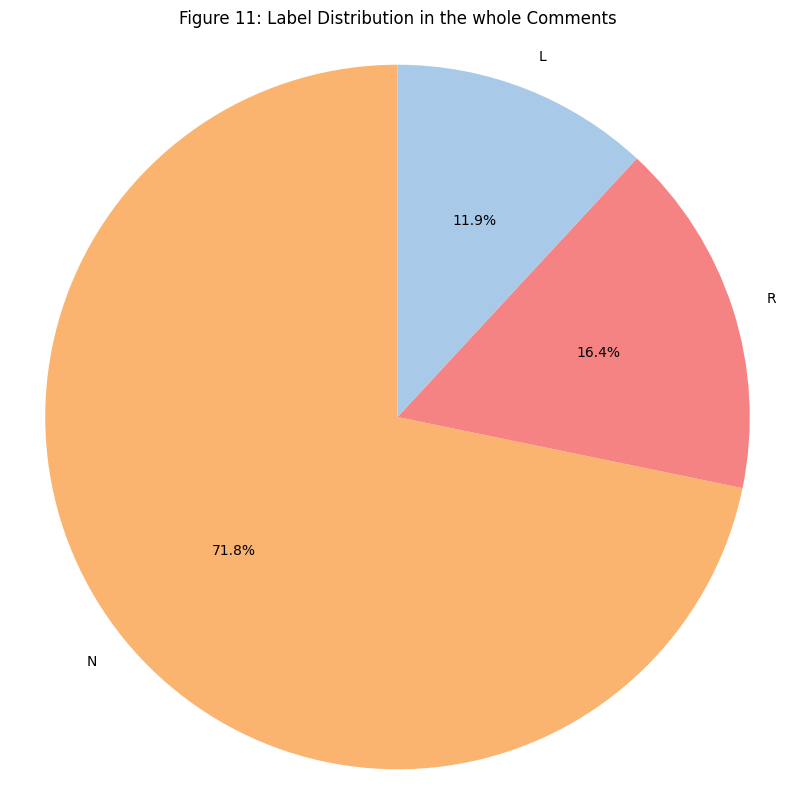

In [ ]:
label_counts = df['predicted_class'].value_counts()
label_mapping = {0: 'N', 1: 'R', 2: 'L'}
mapped_labels = label_counts.index.map(label_mapping)

colors = ['#FBB46F','#F58383', '#A8CAE8']

plt.figure(figsize=(10, 10))
plt.pie(label_counts, labels=mapped_labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Figure 11: Label Distribution in the whole Comments')
plt.axis('equal')

plt.show()

In [ ]:
results = {}

# Group comments
original_comments = df[df['is_reply'] == False]

# Group replies
replies = df[df['is_reply'] == True]

# Group
for group_name, group_data in df.groupby('predicted_class'):
    internal_links = 0
    external_links = 0


    group_replies = replies[replies['predicted_class'] == group_name]

    for idx, reply in group_replies.iterrows():
        # Find original label
        original_comment_class = original_comments[original_comments['commentId'] == reply['commentId']]['predicted_class'].values[0]

        if original_comment_class == group_name:
            internal_links += 1
        else:
            external_links += 1

    # Accumulation
    results[group_name] = {
        'internal_links': internal_links,
        'external_links': external_links
    }

# Print links for each label
for group_name, counts in results.items():
    print(f"Class {group_name}: Internal links = {counts['internal_links']}, External links = {counts['external_links']}")

# Caculation
ei_index = {}
for group_name, counts in results.items():
    internal_links = counts['internal_links']
    external_links = counts['external_links']
    if internal_links + external_links > 0:
        ei_score = (external_links - internal_links) / (external_links + internal_links)
        ei_index[group_name] = ei_score

print("\nE-I Index for each class:")
print(ei_index)

In [ ]:
link_results_path = '/content/drive/My Drive/link_results.txt'
with open(link_results_path, 'w') as f:
    for group_name, counts in results.items():
        result_str = f"Class {group_name}: Internal links = {counts['internal_links']}, External links = {counts['external_links']}\n"
        print(result_str, end='')
        f.write(result_str)

Class 0: Internal links = 70145, External links = 35868
Class 1: Internal links = 6228, External links = 14709
Class 2: Internal links = 4150, External links = 9296


In [ ]:
ei_index_path = '/content/drive/My Drive/ei_index_results.txt'
with open(ei_index_path, 'w') as f:
    for group_name, counts in results.items():
        internal_links = counts['internal_links']
        external_links = counts['external_links']
        if internal_links + external_links > 0:
            ei_score = (external_links - internal_links) / (external_links + internal_links)
            ei_index[group_name] = ei_score
            ei_str = f"Class {group_name}: E-I Index = {ei_score}\n"
            print(ei_str, end='')
            f.write(ei_str)

Class 0: E-I Index = -0.3233282710610963
Class 1: E-I Index = 0.40507235993695373
Class 2: E-I Index = 0.38271604938271603


In [ ]:
results = {}

# Filter out replies and original comments
original_comments = df[df['is_reply'] == False]
replies = df[df['is_reply'] == True]

# Group by video index and predicted class
for video_index, video_group in df.groupby('video_index'):
    video_results = {}

    for group_name, group_data in video_group.groupby('predicted_class'):
        internal_links = 0
        external_links = 0

        # Filter replies for the current class and video
        group_replies = replies[(replies['predicted_class'] == group_name) & (replies['video_index'] == video_index)]

        # Check replies against original comments
        for idx, reply in group_replies.iterrows():
            # Retrieve original comments with the same video_index and reply's commentId
            matched_originals = original_comments[(original_comments['commentId'] == reply['commentId']) & (original_comments['video_index'] == video_index)]
            if not matched_originals.empty:
                original_comment_class = matched_originals['predicted_class'].values[0]

                if original_comment_class == group_name:
                    internal_links += 1
                else:
                    external_links += 1

        # Store results for this class and video
        video_results[group_name] = {
            'internal_links': internal_links,
            'external_links': external_links
        }

    results[video_index] = video_results

# Print links for each label and video
for video_index, video_results in results.items():
    print(f"Video {video_index}:")
    for group_name, counts in video_results.items():
        print(f"  Class {group_name}: Internal links = {counts['internal_links']}, External links = {counts['external_links']}")

# Calculation of Globally Index for each class in each video
globally_index = {}
for video_index, video_results in results.items():
    video_globally_index = {}
    for group_name, counts in video_results.items():
        internal_links = counts['internal_links']
        external_links = counts['external_links']
        # Calculate Globally Index: (External - Internal) / Total Links
        if internal_links + external_links > 0:
            gi_score = (external_links - internal_links) / (internal_links + external_links)
            video_globally_index[group_name] = gi_score
    globally_index[video_index] = video_globally_index

print("\nGlobally Index for each class in each video:")
for video_index, video_globally_index in globally_index.items():
    print(f"Video {video_index}:")
    for group_name, score in video_globally_index.items():
        print(f"  Class {group_name}: Globally Index = {score}")

Video 1:
  Class 0: Internal links = 281, External links = 473
  Class 1: Internal links = 114, External links = 119
  Class 2: Internal links = 30, External links = 80
Video 2:
  Class 0: Internal links = 1147, External links = 1156
  Class 1: Internal links = 85, External links = 424
  Class 2: Internal links = 190, External links = 344
Video 3:
  Class 0: Internal links = 1587, External links = 1761
  Class 1: Internal links = 370, External links = 492
  Class 2: Internal links = 222, External links = 328
Video 4:
  Class 0: Internal links = 40, External links = 53
  Class 1: Internal links = 4, External links = 8
  Class 2: Internal links = 6, External links = 10
Video 5:
  Class 0: Internal links = 327, External links = 90
  Class 1: Internal links = 6, External links = 52
  Class 2: Internal links = 20, External links = 13
Video 6:
  Class 0: Internal links = 335, External links = 539
  Class 1: Internal links = 86, External links = 156
  Class 2: Internal links = 60, External li

In [ ]:
data = []

for video_index, class_scores in globally_index.items():
    for class_name, gi_score in class_scores.items():
        data.append({'Video Index': video_index, 'Class': class_name, 'Globally Index': gi_score})

index = pd.DataFrame(data)

index['Globally Index'] = pd.to_numeric(index['Globally Index'], errors='coerce')

In [ ]:
class_map = {0: 'N', 1: 'R', 2: 'L'}
index['Class'] = index['Class'].map(class_map)

<ipython-input-23-faba69763b7d>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Class', y='Globally Index', data=index, palette=colors)


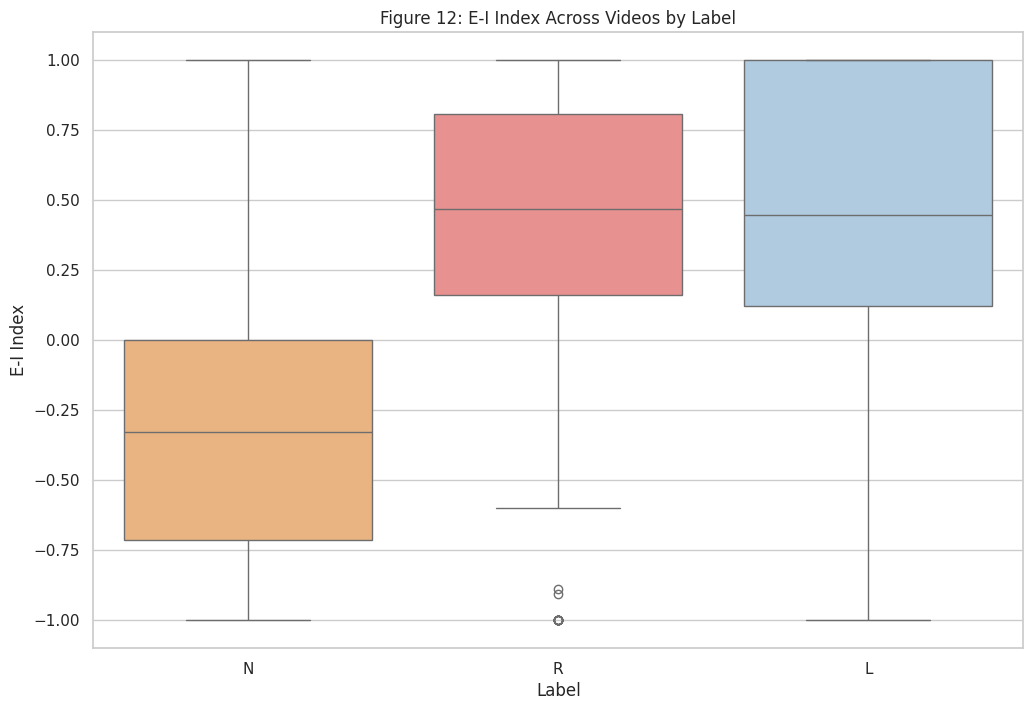

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
colors = ['#FBB46F','#F58383', '#A8CAE8']

plt.figure(figsize=(12, 8))
ax = sns.boxplot(x='Class', y='Globally Index', data=index, palette=colors)

plt.title('Figure 12: E-I Index Across Videos by Label')
plt.xlabel('Label')
plt.ylabel('E-I Index')

plt.xticks()
plt.show()

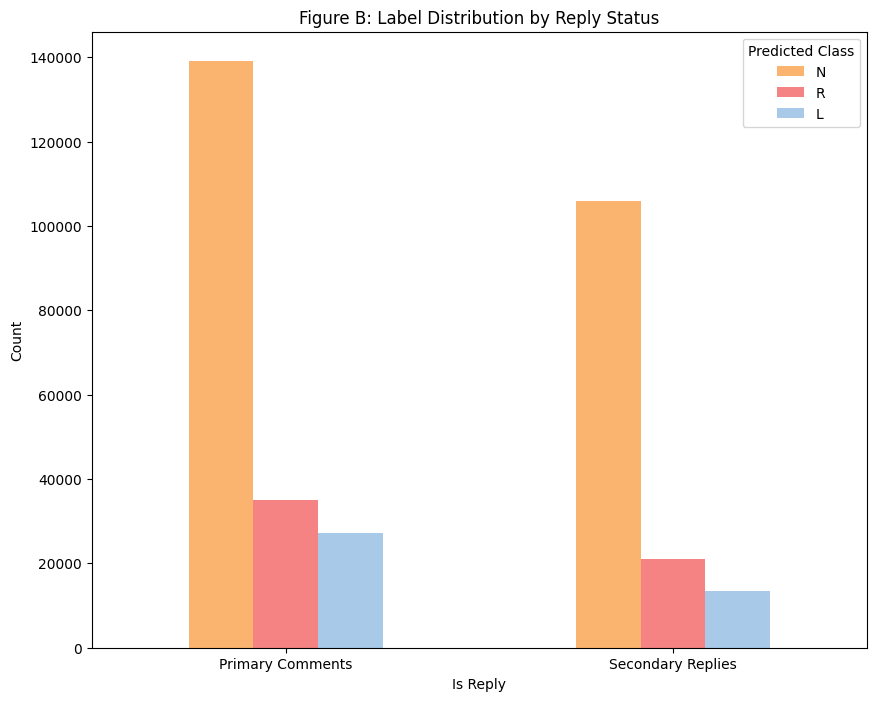

In [ ]:
grouped = df.groupby(['is_reply', 'predicted_class']).size().unstack(fill_value=0)

label_mapping = {0: 'N', 1: 'R', 2: 'L'}
grouped.columns = grouped.columns.map(label_mapping)
grouped.index = grouped.index.map({False: 'Primary Comments', True: 'Secondary Replies'})

colors = ['#FBB46F', '#F58383', '#A8CAE8']
ax = grouped.plot(kind='bar', color=colors, figsize=(10, 8))

plt.title('Figure B: Label Distribution by Reply Status')
plt.xlabel('Is Reply')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Predicted Class')

plt.show()